# Практика 3: Атака Carlini-Wagner (CW) на модели ИИ
 Выполнил студент: Асатрян Давид Робертовись
 Группа: ББМО-01-23
 # Цель задания:
Изучить одну из наиболее мощных атак на модели ИИ — атаку Carlini-Wagner (CW). Задача —
научиться использовать CW для создания противоречивых примеров и исследовать влияние этой
атаки на обученные модели.
# Задачи:
1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы атаки Carlini-Wagner.
3. Реализовать атаку CW с помощью фреймворка Foolbox.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
данных.


# Шаг 1. Загрузка обученной модели и данных MNIST

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('/content/mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9758 - loss: 0.0789
Test accuracy on clean images: 0.9781000018119812


#Шаг 2: Установка необходимых библиотек и импорт библиотек

In [ ]:
!pip install tensorflow foolbox matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt

#Шаг 3:Инициализация Foolbox

In [ ]:
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Создание атаки Carlini-Wagner
attack = fb.attacks.L2CarliniWagnerAttack()

#Шаг 4:Выбор изображения для атаки

tf.Tensor(7, shape=(), dtype=int64)


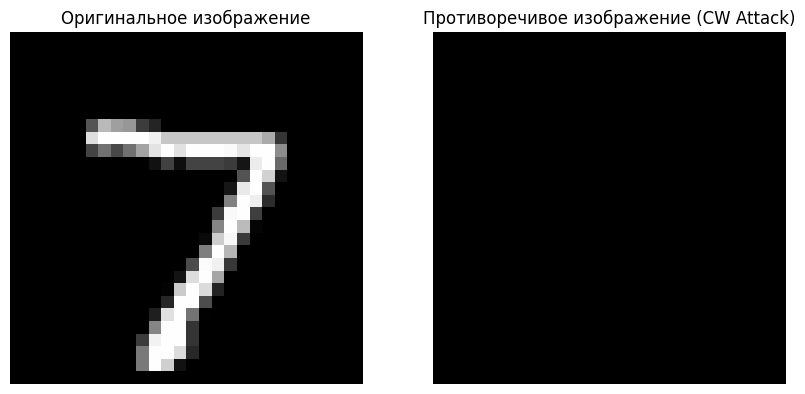

In [ ]:
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Выполнение атаки
attack = fb.attacks.L2CarliniWagnerAttack(steps=3)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Оборачиваем метку в тензор с размерностью (1,)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (CW Attack)")
plt.imshow(advs[0].numpy(), cmap="gray")  # Предполагается, что advs имеет правильную форму
plt.axis('off')

plt.show()

#Шаг 5: Оценка модели на противоречивых примерах

In [1]:
adversarial_images = []
for i in range(len(test_images)):
    # Преобразуем изображение в тензор и добавляем размерность для батча
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]  # Форма (1, height, width, channels)
    label = test_labels[i]  # Получаем метку как скалярное значение

    # Выполнение атаки
    advs, _, success = attack(fmodel, image, label, epsilons=0.01)  # Используем epsilons=0.01
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)  # Объединение по нулевой оси

# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images.numpy(), test_labels)
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 99% - accuracy: 0.0720 - loss: 2.2640
Accuracy on adversarial examples (CW attack): 0.07280000299215317


Вывод:
Точность модели на атакованных примерах значительно снизилась, и является около 0% (особенно если сравнивать с точностью на исходных данных) в зависимости от силы и шагов атаки.

Такое падение точности говорит о том, что модель не справляется с задачей распознавания в условиях небольших, но целенаправленных искажений. Это подчеркивает важность разработки более устойчивых моделей и применения методов защиты от атак, чтобы улучшить надежность в реальных приложениях.